<a href="https://colab.research.google.com/github/Borja-rg/idal_ia3/blob/main/Smoke_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://static.casadomo.com/media/2020/02/lonmark-espana-universidad-valencia-jornada-automatizacion.png" align="right" style="float" width="300">


# **WILDFIRE SMOKE CLASSIFICATION**

### Borja Ramón Gómez 

En este notebook se analizan recortes de fotografías de bosques con humo causado por un incendio, provenientes del Wildfire Smoke Dataset, realizado por aiformankind.org.  El objetivo es diseñar una CNN capaz de clasificar las imágenes en función de si tienen humo o no para, posteriormente, aplicar el modelo a imágenes completas. Esta tarea consta de los siguientes pasos:

1.   Importación y preparación de los datos de entrenamiento, validación y testeo.
2.   Diseño de redes convolucionales y entrenamiento.
3.   Obtención de predicciones sobre el conjunto de testeo realizadas por las CNN y comparación de resultados.
4.   Obtención de predicciones sobre imágenes completas



In [2]:
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Importación y Preparación de Datos**

A continuación se importan las imágenes utilizadas. 2000 imágenes divididas equitativamente entre la clase Humo y No Humo, son repartidas entre los conjuntos de entrenamiento, validación y testeo con unos ratios de 70%, 20% y 10% respectivamente.

In [ ]:
!unzip drive/MyDrive/SMOKE/grid_smoke_version.zip

In [5]:
smoke = glob('grid_smoke_version/train/grid_smoke/*png')
full_no_smoke = glob('grid_smoke_version/train/grid_no_smoke/*png')
random.shuffle(smoke)
random.shuffle(full_no_smoke)
no_smoke = full_no_smoke[:len(smoke)]

train_ratio = 0.7
val_ratio = 0.2

num_smoke = len(smoke)
num_nosmoke = len(no_smoke)

train_smoke = smoke[:round(train_ratio*num_smoke)]
train_nosmoke = no_smoke[:round(train_ratio*num_nosmoke)]

val_smoke = smoke[round(train_ratio*num_smoke):round((train_ratio+val_ratio)*num_smoke)]
val_nosmoke = no_smoke[round(train_ratio*num_nosmoke):round((train_ratio+val_ratio)*num_nosmoke)]

test_smoke = smoke[round((train_ratio+val_ratio)*num_smoke):]
test_nosmoke = no_smoke[round((train_ratio+val_ratio)*num_nosmoke):]

train_X = train_smoke + train_nosmoke
train_y = len(train_smoke) * ['Smoke'] + len(train_nosmoke)*['No smoke']

val_X = val_smoke + val_nosmoke
val_y = len(val_smoke) * ['Smoke'] + len(val_nosmoke)*['No smoke']

test_X = test_smoke + test_nosmoke
test_y = len(test_smoke) * ['Smoke'] + len(test_nosmoke)*['No smoke']

df_train = pd.DataFrame(columns=['filepath','class'])
df_train['filepath'] = train_X
df_train['class'] = train_y

df_val = pd.DataFrame(columns=['filepath','class'])
df_val['filepath'] = val_X
df_val['class'] = val_y

df_test = pd.DataFrame(columns=['filepath','class'])
df_test['filepath'] = test_X
df_test['class'] = test_y

In [6]:
tot = len(smoke)+len(no_smoke)
print(f'Number of total images: \nSmoke = {len(smoke)} ({round(len(smoke)/tot*100,2)} %)\nNo smoke = {len(no_smoke)} ({round(len(no_smoke)/tot*100,2)} %)')
print(f'Ratios: Train 70%, Validation 20%, Test 10%')

Number of total images: 
Smoke = 999 (50.0 %)
No smoke = 999 (50.0 %)
Ratios: Train 70%, Validation 20%, Test 10%


In [ ]:
sizes = {}
for i in range(len(train_smoke)):
  im = train_smoke[i]
  image = load_img(im)
#  display(image)
  size = np.array(image).shape
  if size not in sizes:
    sizes[size] = 1
  else:
    sizes[size] += 1
sizes

{(170, 227, 3): 358, (227, 341, 3): 341}

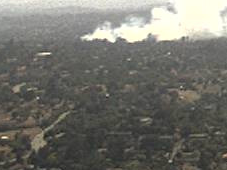

In [ ]:
display(load_img(smoke[300]))

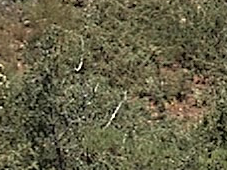

In [ ]:
display(load_img(no_smoke[300]))

Con el objetivo de no cargar todas las imágenes a memoria, se crea un generador para cada set de datos que introduce progresivamente los datos en batches.

Además, se ha decidido realizar data augmentation para el conjunto de entrenamiento, dada la reducida cantidad de datos disponibles.

In [7]:
batch_size = 32
target_size = (227,341)

train_gen = ImageDataGenerator(dtype='float32',
                              preprocessing_function = lambda x:x/255,
                              rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              fill_mode='nearest',
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True)

val_gen  = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

test_gen = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

In [8]:
train_generator = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 1398 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [ ]:
val_generator.class_indices

{'No smoke': 0, 'Smoke': 1}

In [ ]:
input_shape = (227, 341, 3)

## **2. Diseño y Entrenamiento de CNNs**

En esta sección se diseña una función para crear redes convolucionales ligéramente diferentes con el objetivo de comparar sus rendimientos y obtener los parámetros óptimos

In [12]:
def cnn_model(optimizer, dropout, comp=True, glob_avg=False, extra_dense = False, regul = None):

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu',input_shape=(227, 341, 3)))
    if comp:
      model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3,3), activation='relu'))
    if comp:
      model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    if glob_avg:
      model.add(GlobalAveragePooling2D())
    else:
      model.add(Flatten())
    
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu',kernel_regularizer = regul))
    model.add(Dropout(dropout))
    if extra_dense:
      model.add(Dense(16, activation='relu',kernel_regularizer = regul))
      model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax')) 
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [13]:
model_1 = cnn_model('adam', 0.5, regul='l2')
model_2 = cnn_model(keras.optimizers.RMSprop(),0.5,regul='l2')
model_3 = cnn_model('adam',0.35)
model_4 = cnn_model('adam',0.5, glob_avg = True)
model_5 = cnn_model('adam',0.35,comp = False)
model_6 = cnn_model('adam',0.35,comp = False,glob_avg = True)

In [ ]:
epochs = 20
modelpath = "best_model.h5"
callback = [ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max')]

In [ ]:
history_1 = model_1.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_2 = model_2.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_3 = model_3.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_4 = model_4.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_5 = model_5.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

history_6 = model_5.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

## **3. Obtención de Resultados y Comparativas**

Tras entrenar las redes, se programan unas funciones para interpretar los resultados gráficamente. A continuación se obtienen las gráficas de *accuracy* y *loss* para cada modelo, así como el área bajo la curva (*auc*) y la matriz de confusión.

In [ ]:
from matplotlib.ticker import MaxNLocator

def training_graph(history):
  tr_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  tr_loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_i = val_acc.index(max(val_acc))

  plt.figure(figsize=(15,7))
  ax = plt.subplot(1,2,1)
  plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
  plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
  plt.plot(1+best_i, 100*val_acc[best_i], 'or')
  plt.title('Model accuracy (%)', fontsize=18)
  plt.ylabel('Accuracy (%)', fontsize=18)
  plt.xlabel('Epoch', fontsize=18)
  plt.legend(['Train', 'Validation'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  plt.subplot(1,2,2)
  plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
  plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
  plt.plot(1+best_i, val_loss[best_i], 'or')
  plt.title('Model Loss', fontsize=18)
  plt.ylabel('Loss', fontsize=18)
  plt.xlabel('Epoch', fontsize=18)
  plt.legend(['Train', 'Validation'], loc='upper left')
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.show()

def scores(model, train_gen, val_gen, test_gen):
  scores_tr = model.evaluate(train_gen)
  print('Train loss    :', scores_tr[0])
  print('Train accuracy:', scores_tr[1])
  print()

  scores_val = model.evaluate(val_gen)
  print('Val loss    :', scores_val[0])
  print('Val accuracy:', scores_val[1])
  print()

  scores_te = model.evaluate(test_gen)
  print('Test loss     :', scores_te[0])
  print('Test accuracy :', scores_te[1])

def get_roc(models, test_gen, pos_class=1):
  y_real = np.array(test_gen.classes)
  fig, ax1 = plt.subplots(1,1)
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  aspect = ['r--','g--','m--','c--','ro-','go-','c--','m--']
  aucs = []
  for i in range(len(models)):
    model = models[i]
    c = aspect[i]
    y_pred_proba = model.predict(test_gen)
    fpr, tpr, thresholds = roc_curve(y_real==pos_class, y_pred_proba[:,pos_class])
    au = auc(fpr, tpr)
    ax1.plot(fpr, tpr, c , label = f'CNN {i+1} ({au:.2f})')
    aucs.append(au)
  ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
  ax1.legend();
  plt.show()
  return aucs

def conf_matrix(model,test_gen,threshold):
  y_real = np.array(test_gen.classes)
  y_pred_proba = model.predict(test_gen)
  y_pred = np.argmax(y_pred_proba, axis=1)
  y_pred_2 = np.array([1 if pred[1]>threshold else 0 for pred in y_pred_proba])
  cm = confusion_matrix(y_real, y_pred_2)
  plt.imshow(cm, cmap=plt.cm.Blues)
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  plt.xticks([0,1])
  plt.yticks([0,1])
  plt.title('Confusion matrix ')
  plt.colorbar()
  plt.show()
  print(cm)

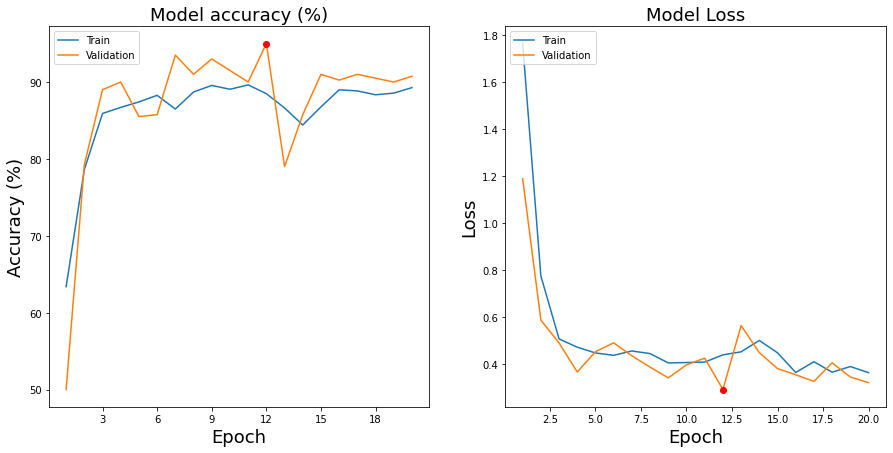

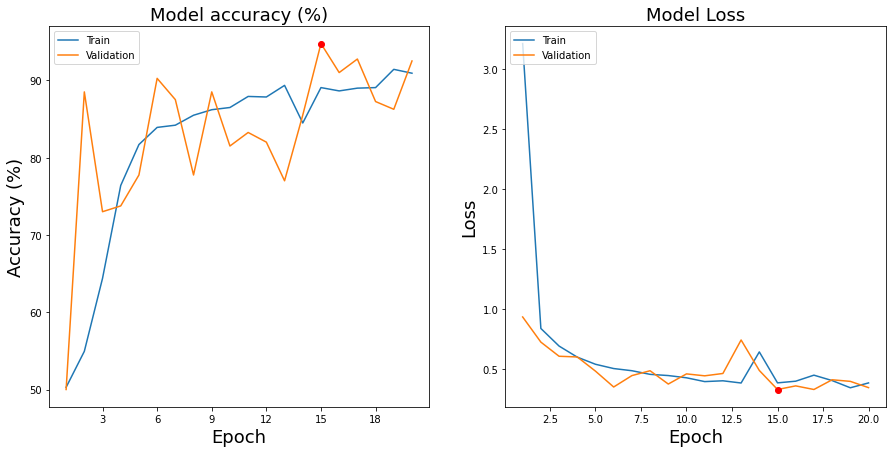

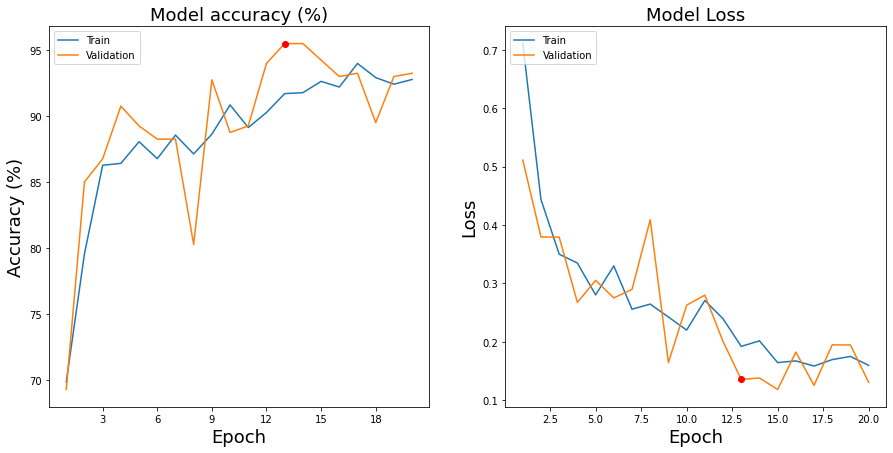

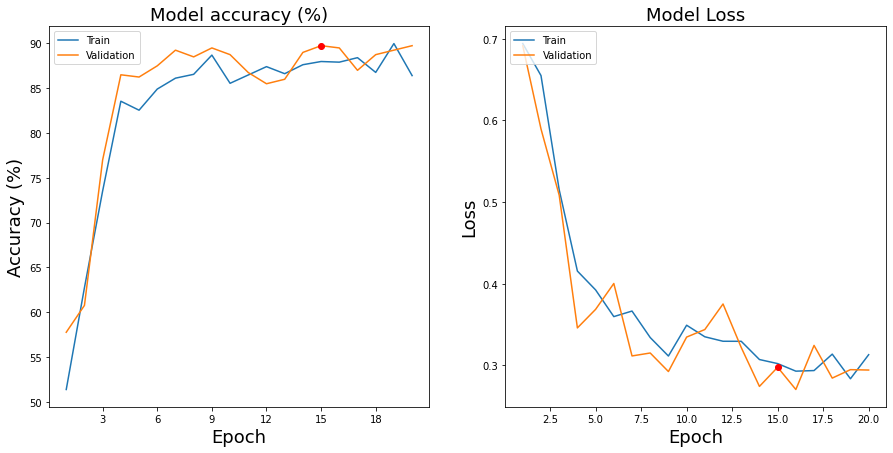

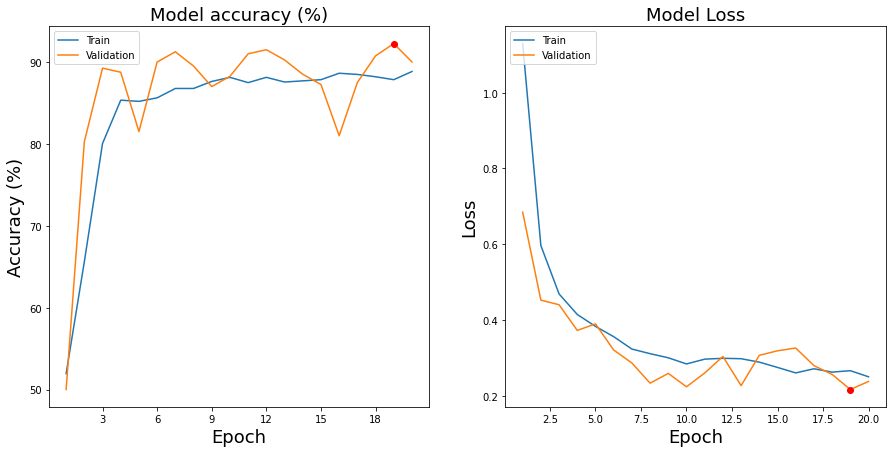

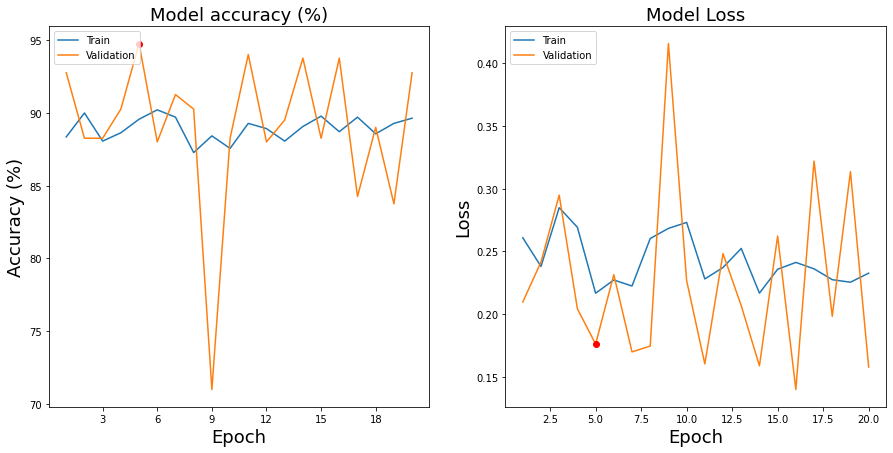

In [ ]:
training_graph(history_1)
training_graph(history_2)
training_graph(history_3)
training_graph(history_4)
training_graph(history_5)
training_graph(history_6)

In [ ]:
scores(model_3,train_generator,val_generator,test_generator)

44/44 [==============================] - 23s 533ms/step - loss: 0.1538 - accuracy: 0.9278
Train loss    : 0.15378527343273163
Train accuracy: 0.9277539253234863

13/13 [==============================] - 1s 100ms/step - loss: 0.1306 - accuracy: 0.9325
Val loss    : 0.13055352866649628
Val accuracy: 0.9325000047683716

7/7 [==============================] - 1s 95ms/step - loss: 0.1361 - accuracy: 0.9400
Test loss     : 0.13606412708759308
Test accuracy : 0.9399999976158142


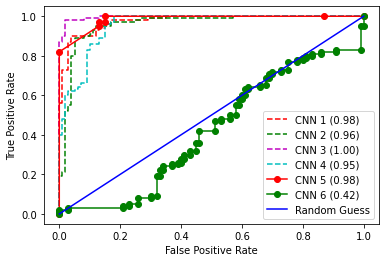

In [ ]:
aucs = get_roc([model_1,model_2,model_3,model_4,model_5,model_6],test_generator)

In [ ]:
model_3.summary()

In [ ]:
model_4.summary()

Observando tanto las curvas durante el entrenamiento, como la gráfica del área bajo la curva, se puede concluir que los modelos del 1 al 5 clasifican con gran acierto las imágenes. En particular, el modelo nº 3. 

Cabe destacar que, mientras que el modelo nº 3 consta de más de 8 millones de parámetros, el modelo nº 4 obtiene resultados excelentes con apenas 150.000 parámetros.

Dados los extraordinarios resultados de la red nº 3, es interesante visualizar la matriz de confusión. En concreto, se ha utilizado un umbral del 0.3, a partir del cual se considera humo. Esta modificación en el umbral de 0.5 a 0.3 permite reducir al mínimo los falsos positivos y falsos negativos.

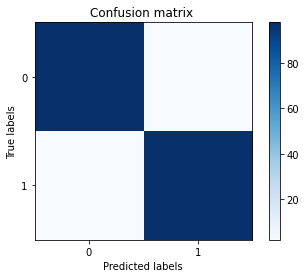

[[98  2]
 [ 2 98]]


In [ ]:
conf_matrix(model_3,test_generator,0.3)

## **4. Obtención de Predicciones sobre Imágenes Completas**

Los modelos obtenidos han sido entrenados con secciones de imágenes. En este apartado se prueba la eficacia de estos modelos aplicandolos a imágenes completas.

Para ello se han dividido las imágenes a analizar en un grid de imágenes del tamaño de entrada de las redes convolucionales. Se ha realizado una predicción independiente para cada una de las subimágenes. Finalmente se ha vuelto a ensamblar la imagen para mostrar gráficamente las predicciones obtenidas.

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot

def image_grid(path, grid_h, grid_w):
  image = np.array(load_img(path))
  h, w, _ = image.shape
  grid_dim = (h//grid_h, w//grid_w)
  rem_h, rem_w = h%grid_h, w%grid_w
  image_res = image[rem_h//2:(h-rem_h+rem_h//2),rem_w//2:(w-rem_w+rem_w//2),:]
  
  grid = []
  for i in range(grid_dim[0]):
    row = []
    for j in range(grid_dim[1]):
      row.append(image_res[i*grid_h:(i+1)*grid_h,j*grid_w:(j+1)*grid_w,:])
    grid.append(row)
  return grid, image_res

def predict_grid(model,grid,threshold,class_indices):
  results = []
  for i in range(len(grid)):
    row = []
    for j in range(len(grid[i])):
      image = np.true_divide(grid[i][j],255)
      p_s = model.predict(np.expand_dims(image, axis=0))[0][class_indices["Smoke"]]
      if p_s>threshold:
        est = 1
      else:
        est = 0
      row.append([p_s,est])
    results.append(row)
  return results

def get_coord(results, original):
  new = np.copy(original)
  coord = []
  for i in range(len(results)):
    for j in range(len(results[i])):
      if results[i][j][-1] == 1:
        coord.append((j*341,i*227))
  return coord

def draw_boxes(coord, original, save=False, save_filename = 'file.jpg'):
  height, width, nbands = original.shape
  dpi = 100
  figsize = width / float(dpi), height / float(dpi)

  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')

  rects = []
  for c in coord:
    rects.append(Rectangle(c,341,227, linewidth = 2, edgecolor='r', facecolor="none"))

  ax.imshow(resized, interpolation='nearest')
  for rect in rects:
    ax.add_patch(rect)

  if save:
    fig.savefig(save_filename, dpi=dpi, transparent=True)
  plt.close()
  return fig

In [ ]:
im = 'test.jpg' # model_1, 0.97 ---- model_4, 0.89
grid, resized = image_grid(im,227,341)
results = predict_grid(model_4, grid, 0.85,val_generator.class_indices)
coord = get_coord(results,resized)
figure = draw_boxes(coord, resized)

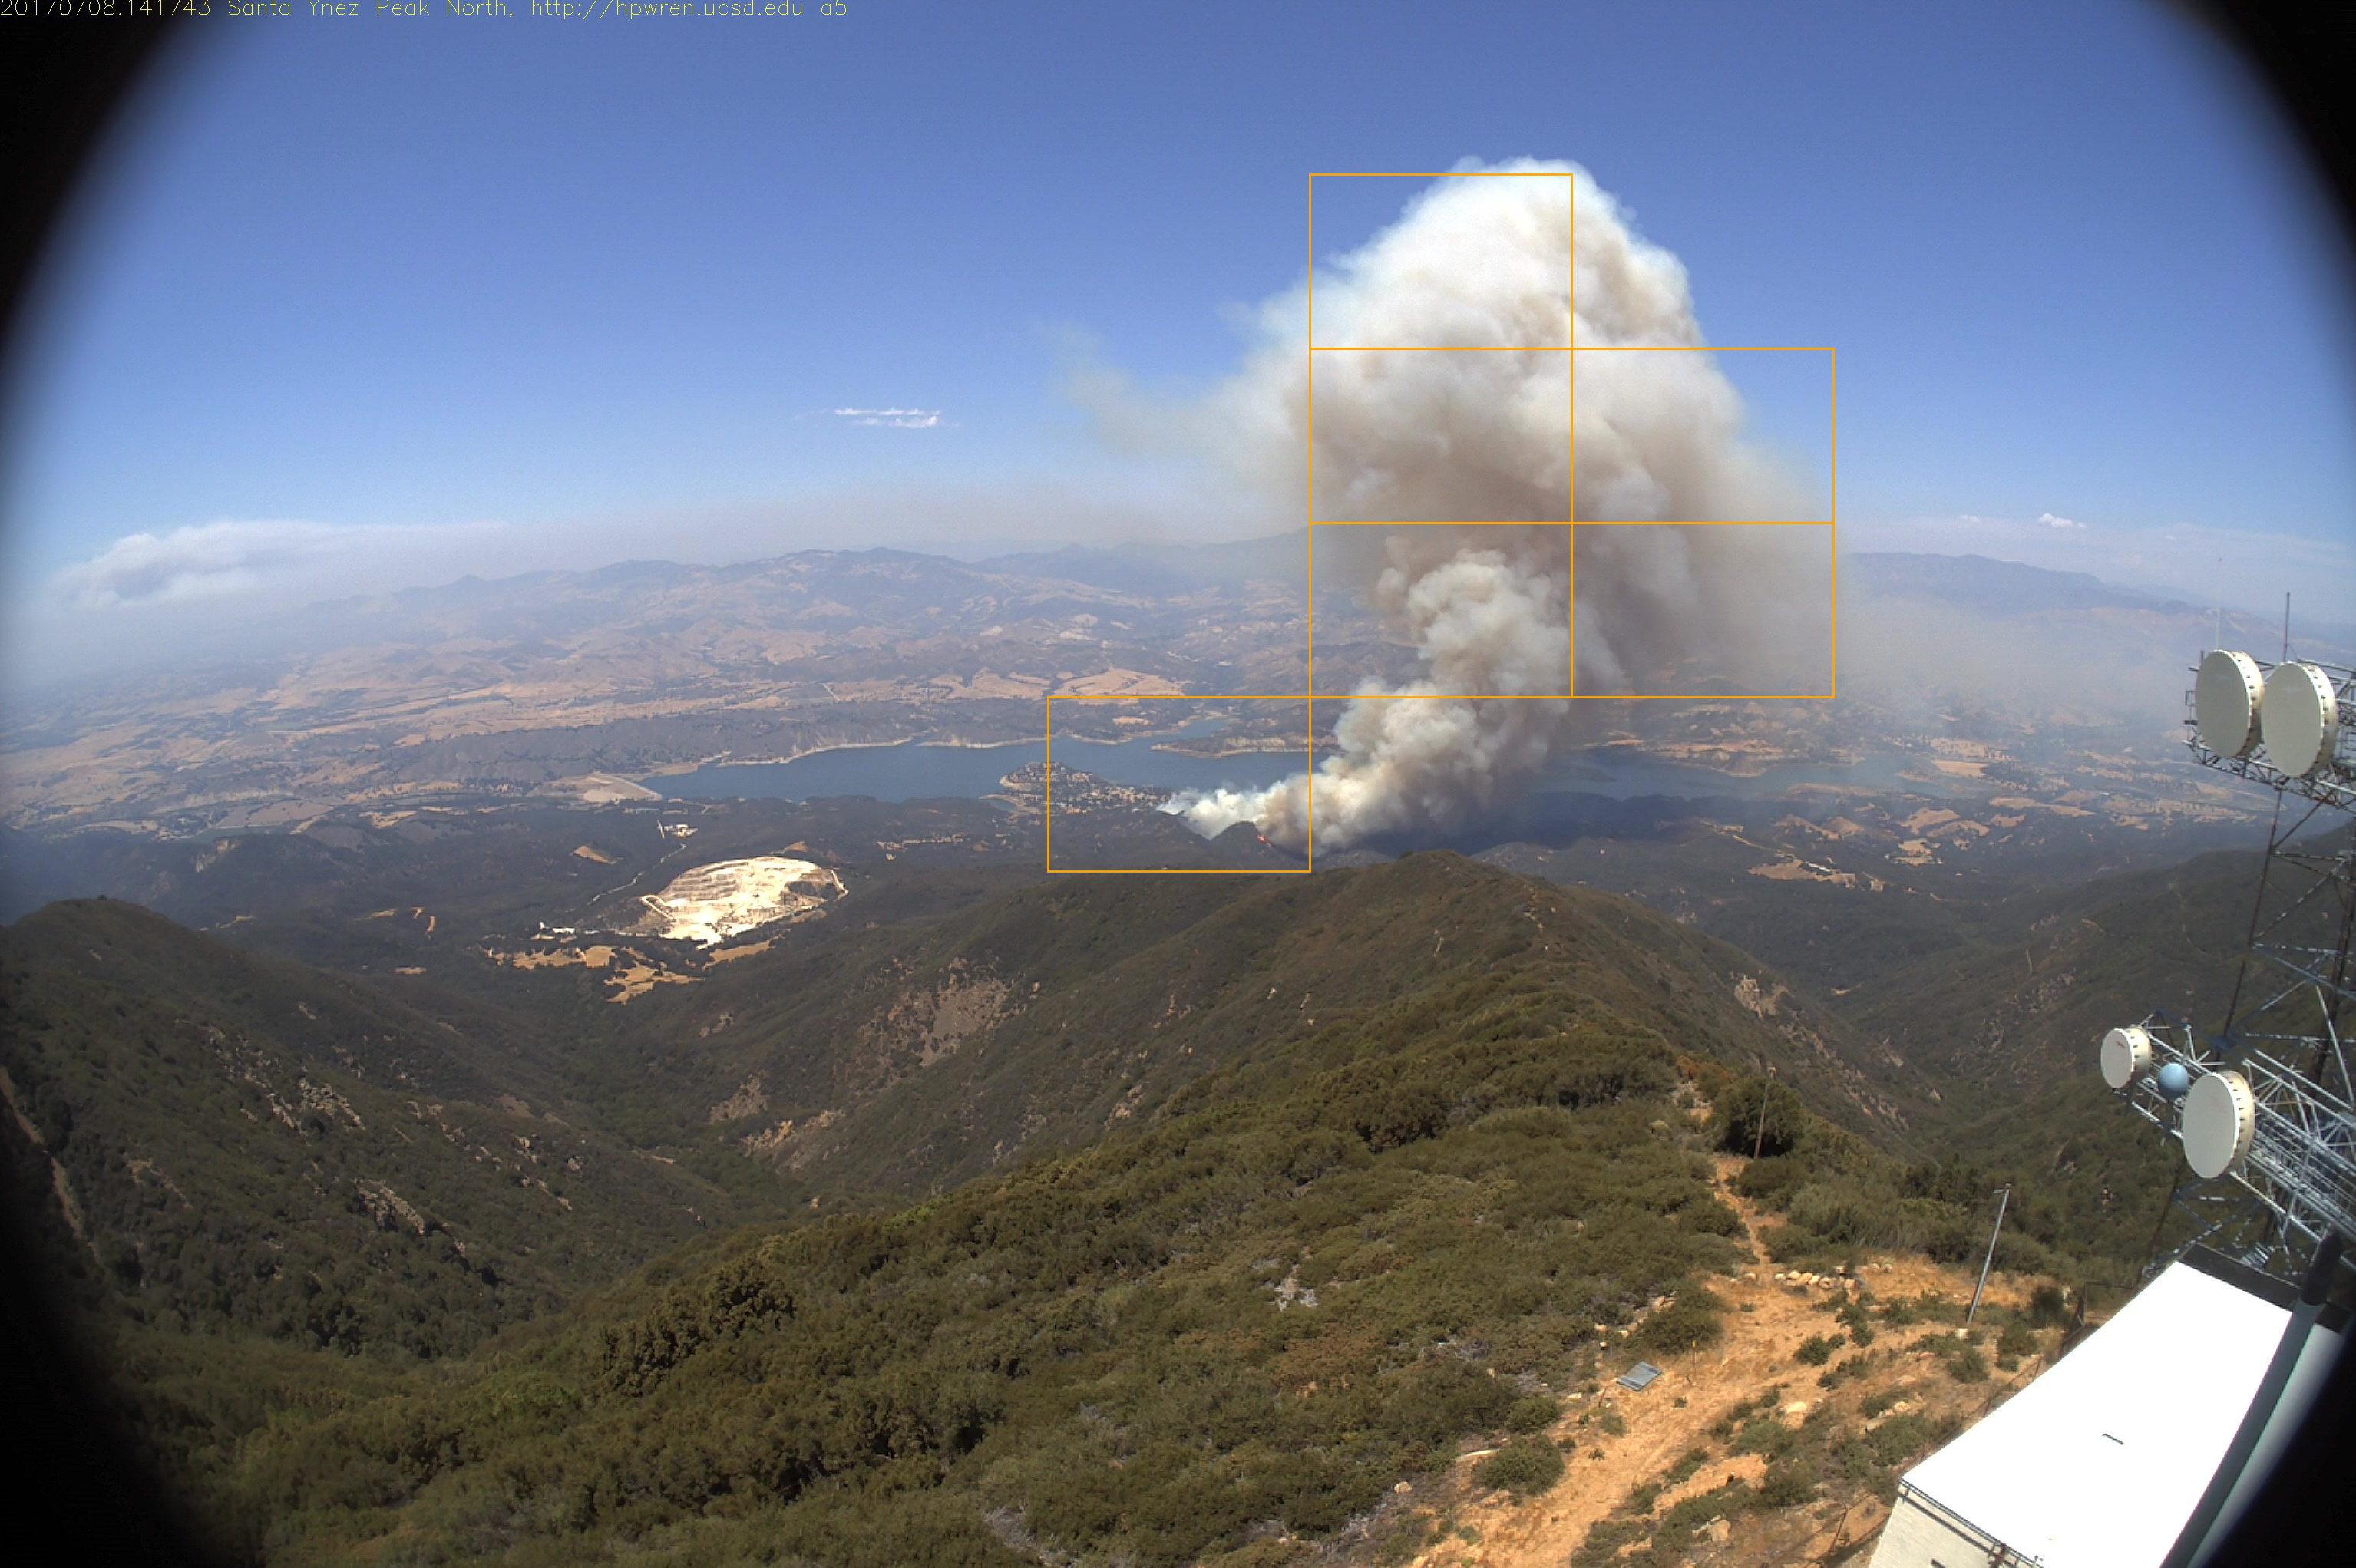

In [ ]:
figure

Se puede observar que la red es capaz de detectar humo en algunas de las subimágenes. Sin embargo, hay que tener en cuenta que se ha utlizado un umbral de detección muy alto, ya que para un umbral de 0.5 la niebla y las nubes también eran detectados como humo.

De este resultado se puede concluir que el procedimiento seguido puede ser utilizado para la clasificiación y detección de humo, pero la base de datos disponible es muy escasa y el procedimiento de análisis es más lento que si se pudiera analizar la imagen entera.

In [ ]:
series = glob('1499*.jpg')
series.sort()
analysed = []
for i in range(len(series)):
  pic = series[i]
  grid, resized = image_grid(pic,227,341)
  results = predict_grid(model_1, grid, 0.95,val_generator.class_indices)
  coord = get_coord(results,resized)
  figure = draw_boxes(coord, resized, save=True, save_filename = f'file_{i}.jpg')

In [15]:
model_1.load_weights('model_1.h5')
model_4.load_weights('model_4.h5')

In [16]:
def print_layer_exits(model, layer_ind, image):
  int_model = Model(inputs=model.input, outputs=model.layers[layer_ind].output)
  aux =  np.true_divide(image,255)
  aux = np.expand_dims(aux, axis=0)
  result = int_model.predict(aux)

  plt.figure(figsize=(3,3))
  plt.imshow(image, cmap='gray')
  plt.title('input image', size=12)
  plt.xticks(())
  plt.yticks(())
  plt.show()

  print(f"Exits from layer {int_model.layers[-1].name} (Shape {result.shape})")

  n_exits = result.shape[-1]
  ncols = 4
  nrows = int(np.ceil(n_exits / ncols))

  ma = abs(result).max()

  plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

  for i in range(n_exits):
      plt.subplot(nrows,ncols,i+1)
      plt.imshow(result[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
      plt.imshow(result[0,:,:,i], cmap='viridis')
      plt.xticks(())
      plt.yticks(())
      plt.title('Exit from kernel %d' % i, fontsize=10)

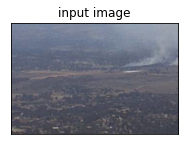

Exits from layer conv2d_1 (Shape (1, 223, 337, 32))


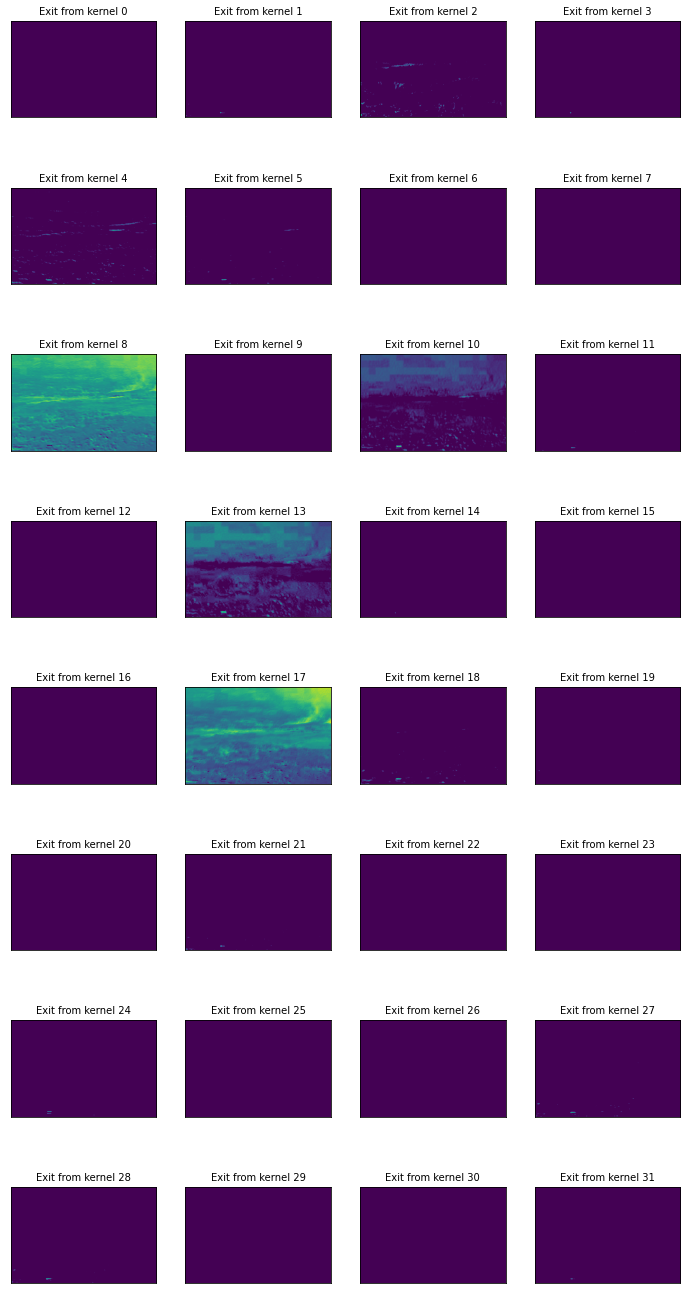

In [18]:
print_layer_exits(model_1, 1, np.array(load_img(smoke[150])))

In [105]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im, class_indices):
    image =  np.true_divide(im,255)
    imag = np.expand_dims(image, axis=0) 
        

    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # output feature map of last conv layer
    with tf.GradientTape() as tape:

        aux = model.output
        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Normalization
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= np.max(heatmap) 
    heatmap = heatmap[0] 

    img = imag[0]
    img = np.zeros((im.shape[0],im.shape[1],3))
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    # We resize the heatmap and convert to RGB
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    

    superposed = heatmap * 0.5 + 0.5*image

    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superposed, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    prob = 100*model.predict(imag)[0][class_indices["Smoke"]]
    print("Probability smoke: {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["No smoke"]]
    print("Probability no smoke: {:2.1f}%".format(prob))
    return heatmap, superposed

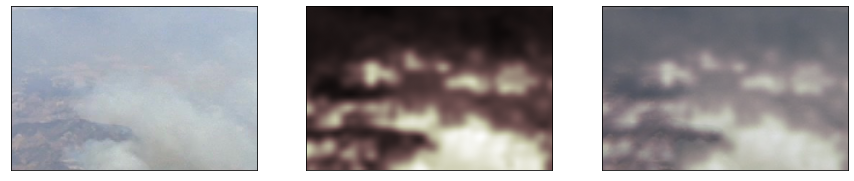

Probability smoke: 83.7%
Probability no smoke: 16.3%





In [106]:
map, sup_img = show_heatmap(model_1, np.array(load_img(smoke[190])),val_generator.class_indices)

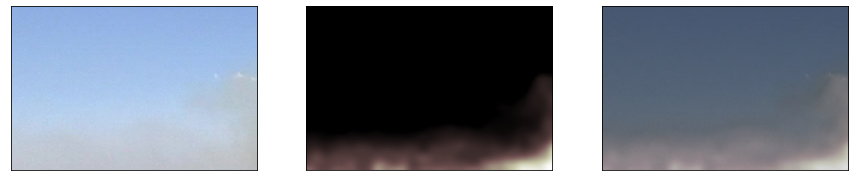

Probability smoke: 77.0%
Probability no smoke: 23.0%





In [107]:
map, sup_img = show_heatmap(model_1, np.array(load_img(smoke[333])),val_generator.class_indices)

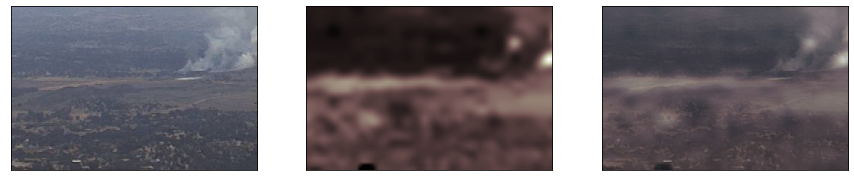

Probability smoke: 72.5%
Probability no smoke: 27.5%





In [108]:
map, sup_img = show_heatmap(model_1, np.array(load_img(smoke[975])),val_generator.class_indices)